# Import Library and preparing dataset with augmentation

In [ ]:
# import all library that will use

import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from PIL import ImageFile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# download file dataset from file
# https://drive.google.com/file/d/1EML4UmDgQFrVv7zbPpdoGp6JSHIg6fOX/view?usp=sharing
!gdown --id 1EML4UmDgQFrVv7zbPpdoGp6JSHIg6fOX

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1EML4UmDgQFrVv7zbPpdoGp6JSHIg6fOX
To: /content/Skin-disease+normal.zip
100% 38.3M/38.3M [00:00<00:00, 214MB/s] 


In [ ]:
# extract file dataset to tmp folder in google colab

zip_ref = zipfile.ZipFile("Skin-disease+normal.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()


In [ ]:
# describe training, validation, and testing directory
base_dir = '../tmp/Skin-disease'

train_dir = os.path.join(base_dir, 'Train')
valid_dir = os.path.join(base_dir, 'Valid')
test_dir = os.path.join(base_dir, 'Test')

# All images will be rescaled by 1./255. and get some augmentation
train_datagen = ImageDataGenerator(rescale = 1.0/255.0 ,
                                   rotation_range=45,
                                   width_shift_range=0.2,      
                                   height_shift_range=0.2,      
                                   shear_range=0.2,      
                                   zoom_range=0.4,      
                                   horizontal_flip=True,      
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale = 1.0/255.0 ,
                                   rotation_range=45,
                                   width_shift_range=0.2,      
                                   height_shift_range=0.2,      
                                   shear_range=0.2,      
                                   zoom_range=0.4,      
                                   horizontal_flip=True,      
                                   fill_mode='nearest')
test_datagen  = ImageDataGenerator(rescale = 1.0/255.0 ,
                                   rotation_range=45,
                                   width_shift_range=0.2,      
                                   height_shift_range=0.2,      
                                   shear_range=0.2,      
                                   zoom_range=0.2,      
                                   horizontal_flip=True,      
                                   fill_mode='nearest')

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 10,
                                                    shuffle=True,
                                                    class_mode = 'binary',
                                                    target_size = (224,224))

# Flow validation images in batches of 3 using test_datagen generator
validation_generator =  valid_datagen.flow_from_directory(valid_dir,
                                                         batch_size=3,
                                                          shuffle=True,
                                                         class_mode  = 'binary',
                                                         target_size = (224,224))   

# Flow validation images in batches of 3 using test_datagen generator
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size=3,
                                                         class_mode  = 'binary',
                                                         target_size = (224,224))


Found 298 images belonging to 3 classes.
Found 109 images belonging to 3 classes.
Found 39 images belonging to 3 classes.


# Building model with Transfer Learning


In [ ]:
# make class for model
class_name = ['scabies', 'normal', 'scabies']

# using transfer learning to make model
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

IMAGE_SIZE =(224,224)

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,))

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 32)                40992     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                

In [ ]:
# compile the model using Adamaz as optimizer and sparse_categorical_crossentropy as loss
model.compile(optimizer= 'adamax',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


# Train model with datset

In [ ]:
# adding callbaks to stop epocs when its reaches the accuracy we want
class callbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy') > 0.840):
      self.model.stop_training = True

callbacks = callbacks()

# adding checkpoint
path = '/content/drive/My Drive/model/model1.{epoch:02d}-{val_accuracy:.2f}.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=path, monitor='val_accuracy',  verbose=1,
    save_freq='epoch', save_best_only=True, mode='max'
)

In [ ]:
# train the model with 30 epoch and 
# save the best model using callbaks checkpoint
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=30, callbacks=checkpoint)


Epoch 1/30
30/30 [==============================] - ETA: 0s - loss: 1.1609 - accuracy: 0.3758
Epoch 1: val_accuracy improved from -inf to 0.52294, saving model to /content/drive/My Drive/model/model1.01-0.52.h5
30/30 [==============================] - 12s 310ms/step - loss: 1.1609 - accuracy: 0.3758 - val_loss: 0.9946 - val_accuracy: 0.5229
Epoch 2/30
30/30 [==============================] - ETA: 0s - loss: 1.0103 - accuracy: 0.5101
Epoch 2: val_accuracy improved from 0.52294 to 0.63303, saving model to /content/drive/My Drive/model/model1.02-0.63.h5
30/30 [==============================] - 8s 275ms/step - loss: 1.0103 - accuracy: 0.5101 - val_loss: 0.8912 - val_accuracy: 0.6330
Epoch 3/30
30/30 [==============================] - ETA: 0s - loss: 0.9650 - accuracy: 0.5201
Epoch 3: val_accuracy improved from 0.63303 to 0.67890, saving model to /content/drive/My Drive/model/model1.03-0.68.h5
30/30 [==============================] - 8s 270ms/step - loss: 0.9650 - accuracy: 0.5201 - val_los

# Evaluate train model

In [ ]:
loaded.evaluate(test_generator)

13/13 [==============================] - 1s 55ms/step - loss: 0.5117 - accuracy: 0.8205


[0.5117009282112122, 0.8205128312110901]

Text(0.5, 1.0, 'Training and validation loss')

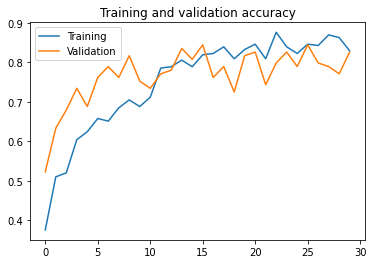

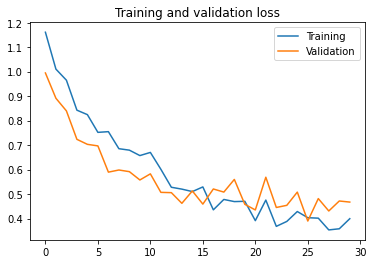

In [ ]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs


plt.plot  ( epochs,     acc, label='Training')
plt.plot  ( epochs, val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot  ( epochs,     loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

# Save and Export Model



In [ ]:
#@title run this code to save as .h5
skin_disease = '/content/drive/My Drive/three_skin_disease_84.h5'

model.save(skin_disease, save_format="h5")

In [ ]:
#@title run this code to save as saved_model.pb
skin_disease = '/content/drive/My Drive/two_skin_disease'

tf.saved_model.save(model, skin_disease)

%%bash -s $two_skin_disease
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

Traceback (most recent call last):
  File "/usr/local/bin/saved_model_cli", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/tools/saved_model_cli.py", line 1260, in main
    args.func(args)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/tools/saved_model_cli.py", line 745, in show
    _show_inputs_outputs(args.dir, args.tag_set, args.signature_def)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/tools/saved_model_cli.py", line 152, in _show_inputs_outputs
    tag_set)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/tools/saved_model_utils.py", line 113, in get_meta_graph_def
    saved_model = read_saved_model(saved_model_dir)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/tools/saved_model_utils.py", line 51, in read_saved_model
    raise IOError("SavedModel file does not exist at: %s" % saved_model_dir)
OSError: SavedModel file does not exist at: /content/dri

# Load the model 

In [ ]:
#@title run this code to load .h5 model
# choose the best model from checkpoint

loaded = keras.models.load_model(
    '/content/drive/My Drive/model/model1.16-0.84.h5', 
    custom_objects={'KerasLayer':hub.KerasLayer})
loaded.get_config()

# Model Prediction


In [ ]:
#@title run this code to load .h5 model
loaded = keras.models.load_model('/content/drive/My Drive/model/model1.16-0.84.h5', custom_objects={'KerasLayer':hub.KerasLayer})
loaded.get_config()


{'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 224, 224, 3),
    'dtype': 'float32',
    'name': 'keras_layer_1_input',
    'ragged': False,
    'sparse': False}},
  {'class_name': 'KerasLayer',
   'config': {'batch_input_shape': (None, 224, 224, 3),
    'dtype': 'float32',
    'handle': 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4',
    'name': 'keras_layer_1',
    'trainable': False}},
  {'class_name': 'Flatten',
   'config': {'data_format': 'channels_last',
    'dtype': 'float32',
    'name': 'flatten_1',
    'trainable': True}},
  {'class_name': 'Dense',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'dtype': 'float32',
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'kernel_regularizer': None,
    'na

In [ ]:
#@title run this code to load saved_model.pb
loaded = tf.saved_model.load(path)

loaded.save()

print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

Saving 28.JPG to 28.JPG


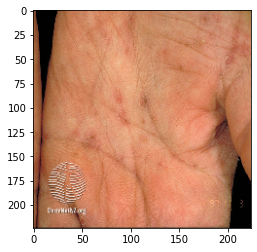

[[0.076605  0.3100668 0.6133282]]
{'persentase': 61.3328218460083, 'prediksi': 'scabies'}


In [ ]:
#@title run this cell and put a images to get predicted by mdodel
from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

# make the label
label = ['chickenpox', 'normal', 'scabies']

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(224, 224))
  plt.imshow(img)
  plt.show()
  
  x=image.img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  #
  pred_arr = loaded.predict(images, batch_size=5)

  # choose the big predict
  predict = np.argmax(pred_arr, axis=1)
  
  print(pred_arr)
  data = {
      'persentase' : np.max(pred_arr)*100, 
      'prediksi' : label[predict[0]]}
  print(data)
  

 

# Convert to TFLite and Download

In [ ]:
#@title use this code to convert keras model to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(loaded)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
open ("three_skin_model.tflite" , "wb") .write(tflite_model)

In [ ]:
#@title use this code convert from saved_model to tflite
converter = tf.lite.TFLiteConverter.from_saved_model(two_skin_disease) 
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
open ("three_skin_model.tflite" , "wb") .write(tflite_model)

# Download the model here

In [ ]:
try:
    from google.colab import files
    files.download('three_skin_model.tflite')

except:
    pass

In [ ]:
try:
    from google.colab import files
    files.download('/content/drive/My Drive/model/model1.16-0.84.h5')

except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>